In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
palette1 = sns.color_palette()
palette2 = sns.color_palette("hls",5)
palette_greys = sns.color_palette("Greys",5)

In [2]:
def rename(df):
    df['modelname_old'] = df['modelname']
    df['modelname'] = df['modelname'].replace('euclidean', 'K-means: Least squares \n(sign-flipped eigenvectors)')
    df['modelname'] = df['modelname'].replace('diametrical', 'K-means: Diametrical')
    df['modelname'] = df['modelname'].replace('complex_diametrical', 'K-means: Complex diametrical')
    df['modelname'] = df['modelname'].replace('grassmann', 'K-means: Grassmann')
    df['modelname'] = df['modelname'].replace('weighted_grassmann', 'K-means: Weighted Grassmann')
    df['modelname'] = df['modelname'].replace('Watson', 'Mixture: Watson')
    df['modelname'] = df['modelname'].replace('Complex_Watson', 'Mixture: Complex Watson')
    df['modelname'] = df['modelname'].replace('ACG', 'Mixture: ACG')
    df['modelname'] = df['modelname'].replace('Complex_ACG', 'Mixture: Complex ACG')
    df['modelname'] = df['modelname'].replace('MACG', 'Mixture: MACG')
    df['modelname'] = df['modelname'].replace('SingularWishart', 'Mixture: Singular Wishart')
    df['modelname'] = df['modelname'].replace('Normal', 'Mixture: Gaussian')
    
# if column LR doesnt exist, make it with zeros
    if 'LR' not in df.columns:
        df['LR'] = 0
    if 'HMM' not in df.columns:
        df['HMM'] = False

    names = [] #without the Kmeans or Mixture or HMM
    names2 = [] #with
    group = []
    for i in range(len(df)):
        if 'Watson' in df['modelname'][i]:
            add_rank = ''
        else:
            add_rank = ' rank='+str(df['rank'][i])
        if df['HMM'][i]:
            add_HMM = 'HMM: '
        else:
            add_HMM = ''
        if 'Mixture' in df['modelname'][i]:
            names.append(df['modelname'][i][8:]+add_rank)
            if df['HMM'][i]:
                names2.append(add_HMM + df['modelname'][i][8:]+add_rank)
            else:
                names2.append(add_HMM + df['modelname'][i]+add_rank)
        else:
            names.append(df['modelname'][i][:8])
            names2.append(df['modelname'][i])
        if df['LR'][i]==0:
            group.append('EM')
        elif df['LR'][i]==0.1 and not df['HMM'][i]:
            group.append('Torch')
        elif df['LR'][i]==0.1 and df['HMM'][i]:
            group.append('HMM')
            
    df['names'] = names
    df['names2'] = names2
    df['group'] = group
    return df

In [3]:
data_folder = '../data/results/torchvsEM_phase_controlled_results/'
df1 = pd.read_csv(data_folder+'phase_narrowband_controlled_euclidean.csv')
df2 = pd.read_csv(data_folder+'phase_narrowband_controlled_diametrical.csv')
df3 = pd.read_csv(data_folder+'phase_narrowband_controlled_complex_diametrical.csv')
df4 = pd.read_csv(data_folder+'phase_narrowband_controlled_grassmann.csv')
df5 = pd.read_csv(data_folder+'phase_narrowband_controlled_weighted_grassmann.csv')
df_kmeans = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df_kmeans = rename(df_kmeans)

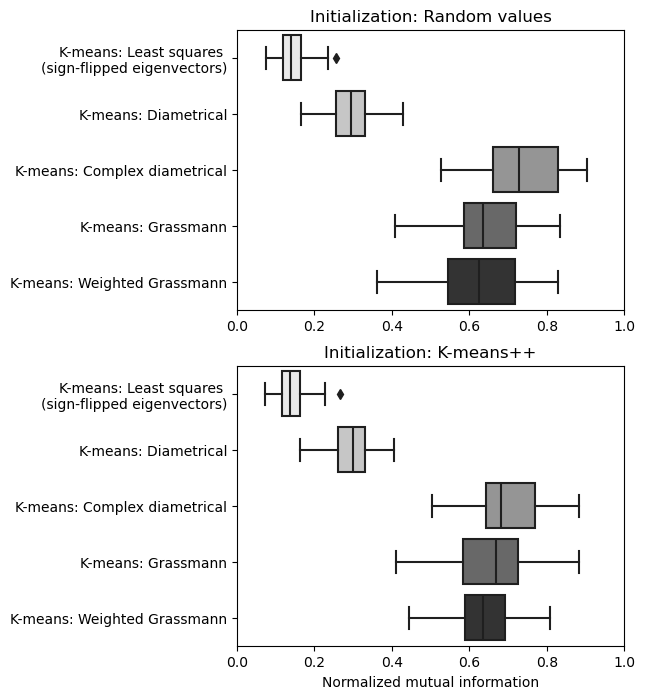

In [4]:
fig,axs = plt.subplots(2,1,figsize=(5,8), sharey=True)
df_tmp = df_kmeans[(df_kmeans['init_method']=='unif')|(df_kmeans['init_method']=='random')]
sns.boxplot(x='train_NMI', y='names2', data=df_tmp, ax=axs[0], palette=palette_greys)
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].set_title('Initialization: Random values')
axs[0].set_xlim([0,1])
sns.boxplot(x='train_NMI', y='names2', data=df_kmeans[df_kmeans['init_method']=='++'], ax=axs[1], palette=palette_greys)
axs[1].set_xlabel('Normalized mutual information')
axs[1].set_ylabel('')
axs[1].set_title('Initialization: K-means++')
axs[1].set_xlim([0,1])
fig.savefig('figures/torchvsEM_phase_narrowband_controlled_results_kmeans.png', bbox_inches='tight', dpi=300)

In [5]:
data_folder = '../data/results/torchvsEM_phase_controlled_results/'

df = pd.DataFrame()
for model in ['Watson','Complex_Watson','ACG','Complex_ACG','MACG','SingularWishart','Normal']:
    for init in ['random','Kmeans','Kmeansseg','ALL']:
        try:
            data = pd.read_csv(data_folder+'phase_narrowband_controlled_'+model+'_init'+init+'.csv')
        except:
            continue
        data = rename(data)
        if init == 'ALL':
            data['initialization'] = 'All'
        elif init == 'Kmeansseg':
            data['initialization'] = 'Analytical \n maximization'
        elif init == 'Kmeans':
            data['initialization'] = 'K-means'
        elif init == 'random':
            data['initialization'] = 'Random'

        # data['initialization'] = init
        df = pd.concat([df, data], ignore_index=True)

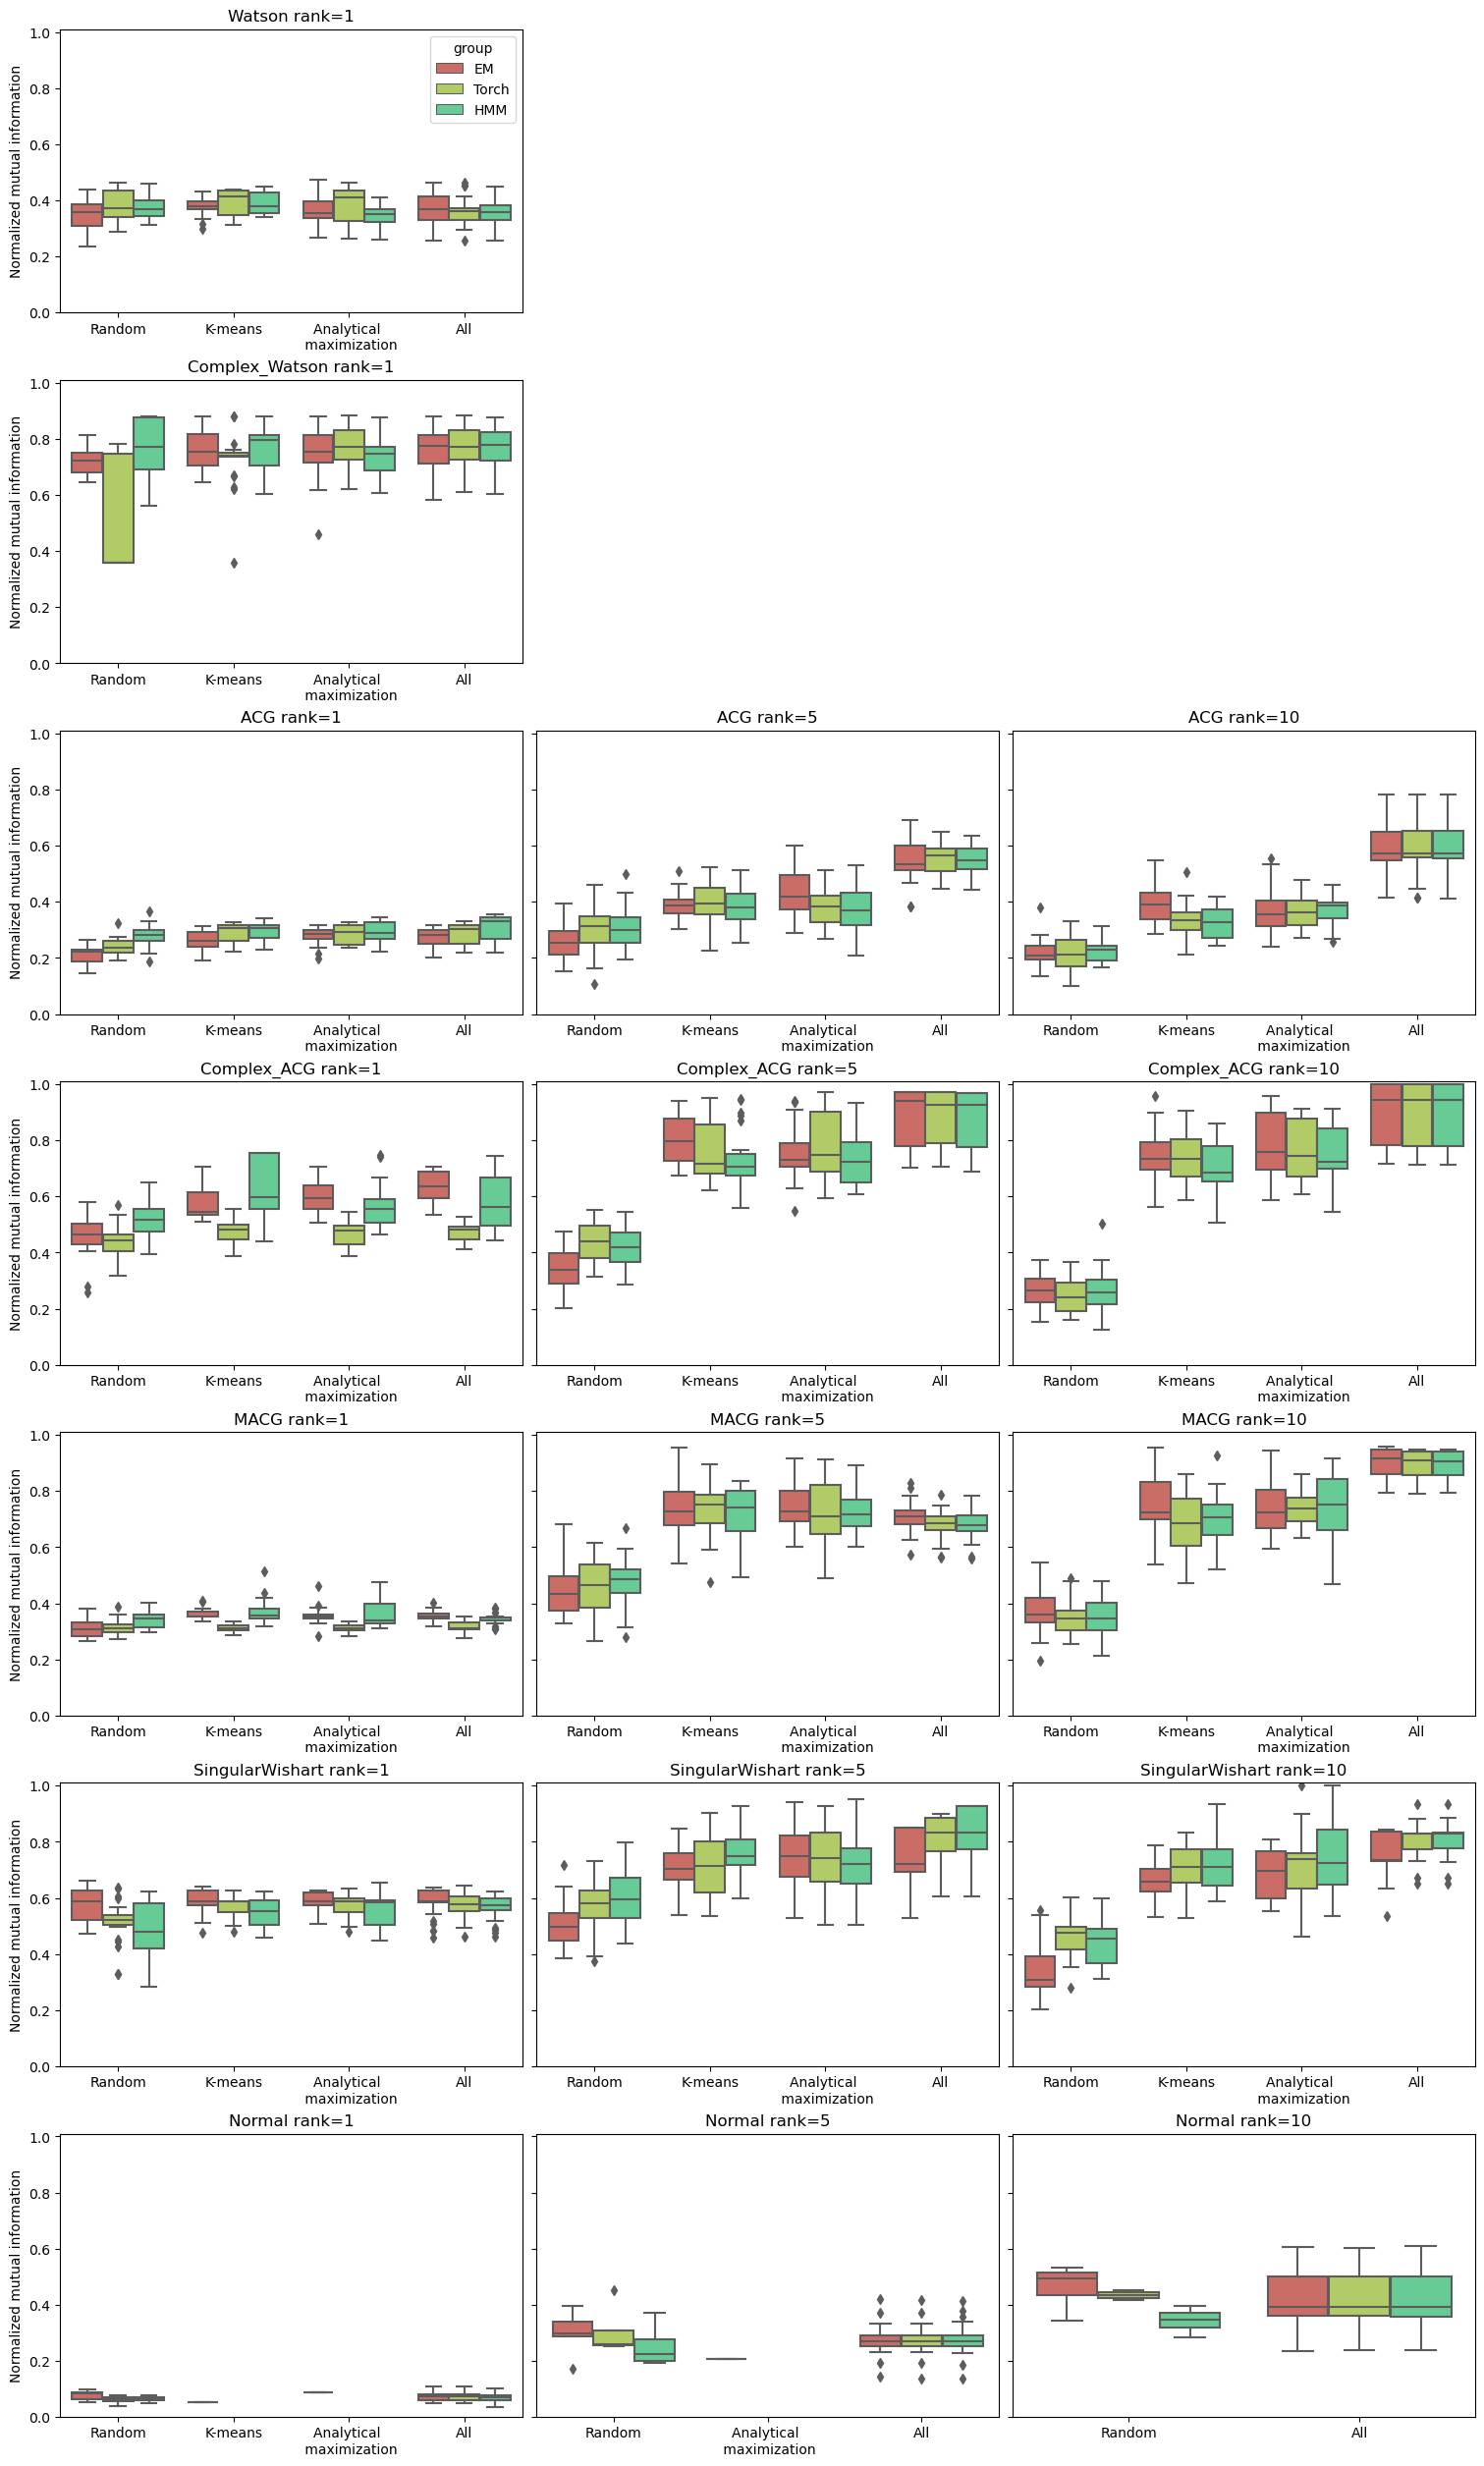

In [6]:
fig,axs = plt.subplots(7,3,figsize=(15,25), sharey=True,layout='constrained')
for i,models in enumerate(['Watson','Complex_Watson','ACG','Complex_ACG','MACG','SingularWishart','Normal']):
    for j,rank in enumerate([1,5,10]):
        if rank!=1 and models in ['Watson','Complex_Watson']:
            axs[i,j].axis('off')
            continue
        df0 = df[df['modelname_old']==models]
        df1 = df0[df0['rank']==rank]
        # df1 = df1[df1['initialization']!='Analytical \n maximization']
        sns.boxplot(y='train_NMI', x='initialization',hue='group', data=df1, ax=axs[i,j], palette=palette2)
        axs[i,j].set_title(models+' rank='+str(rank))
        axs[i,j].set_ylim([0,1.01])
        if j!=0:
            axs[i,j].set_ylabel('')
        else:
            axs[i,j].set_ylabel('Normalized mutual information')
        # if i!=3:
        axs[i,j].set_xlabel('')
        if i!=0 or j!=0:
            axs[i,j].get_legend().remove()
        # axs[i,j].set_xticklabels(axs[i,j].get_xticklabels(), rotation=45)
# plt.savefig('figures/torchvsEM_phase_narrowband_controlled_results.png', bbox_inches='tight', dpi=300)

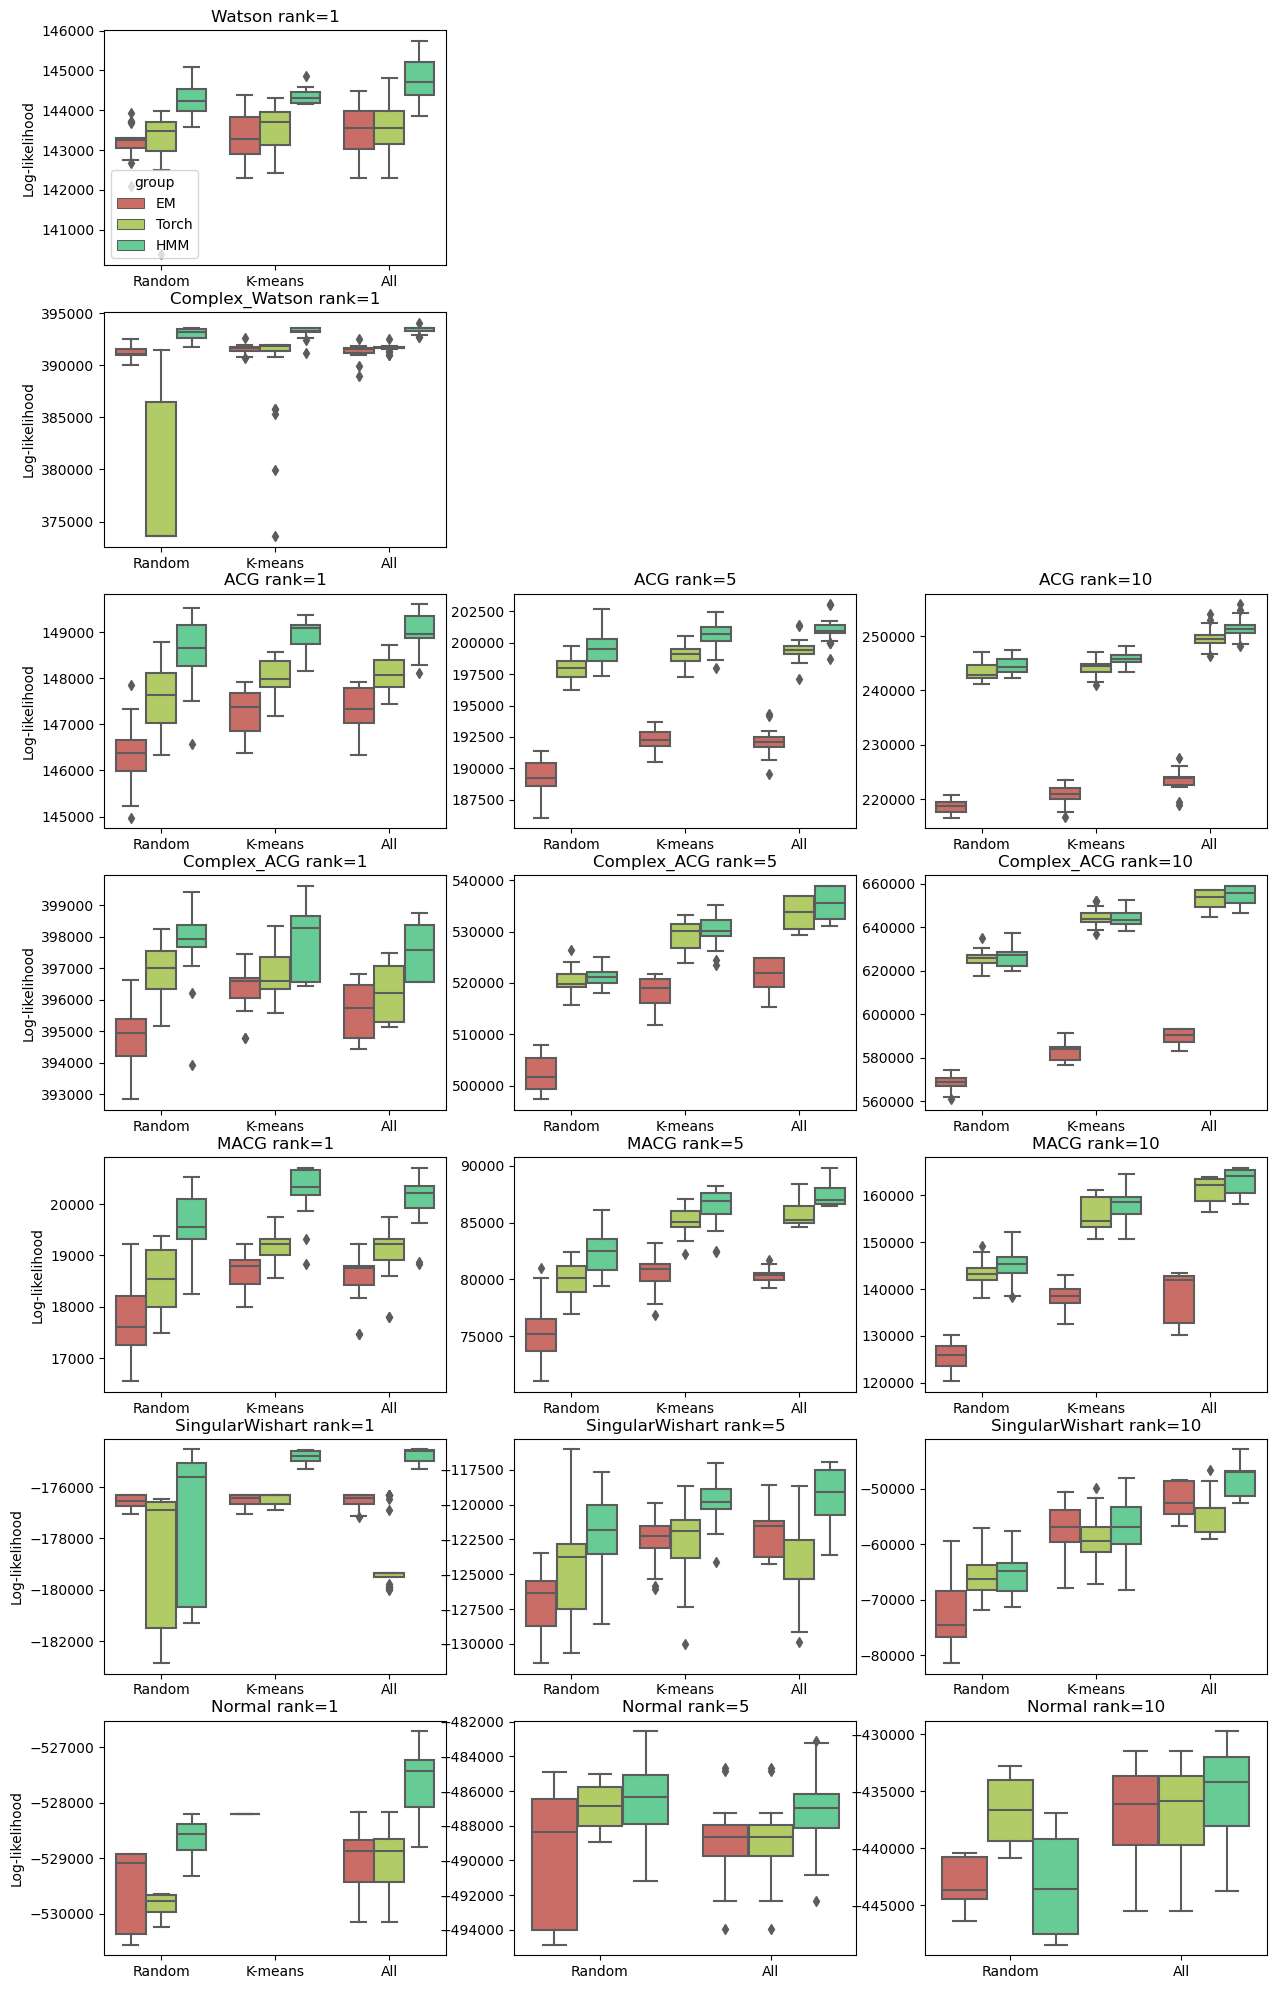

In [7]:
fig,axs = plt.subplots(7,3,figsize=(15,25))
for i,models in enumerate(['Watson','Complex_Watson','ACG','Complex_ACG','MACG','SingularWishart','Normal']):
    for j,rank in enumerate([1,5,10]):
        if rank!=1 and models in ['Watson','Complex_Watson']:
            axs[i,j].axis('off')
            continue
        df0 = df[df['modelname_old']==models]
        df1 = df0[df0['rank']==rank]
        df1 = df1[df1['initialization']!='Analytical \n maximization']
        sns.boxplot(y='train_loglik', x='initialization',hue='group', data=df1, ax=axs[i,j], palette=palette2)
        axs[i,j].set_title(models+' rank='+str(rank))
        # axs[i,j].set_ylim([0,1])
        if j!=0:
            axs[i,j].set_ylabel('')
        else:
            axs[i,j].set_ylabel('Log-likelihood')
        # if i!=3:
        axs[i,j].set_xlabel('')
        if i!=0 or j!=0:
            axs[i,j].get_legend().remove()
        # axs[i,j].set_xticklabels(axs[i,j].get_xticklabels(), rotation=45)
plt.savefig('figures/torchvsEM_phase_narrowband_controlled_results_loglik.png', bbox_inches='tight', dpi=300)

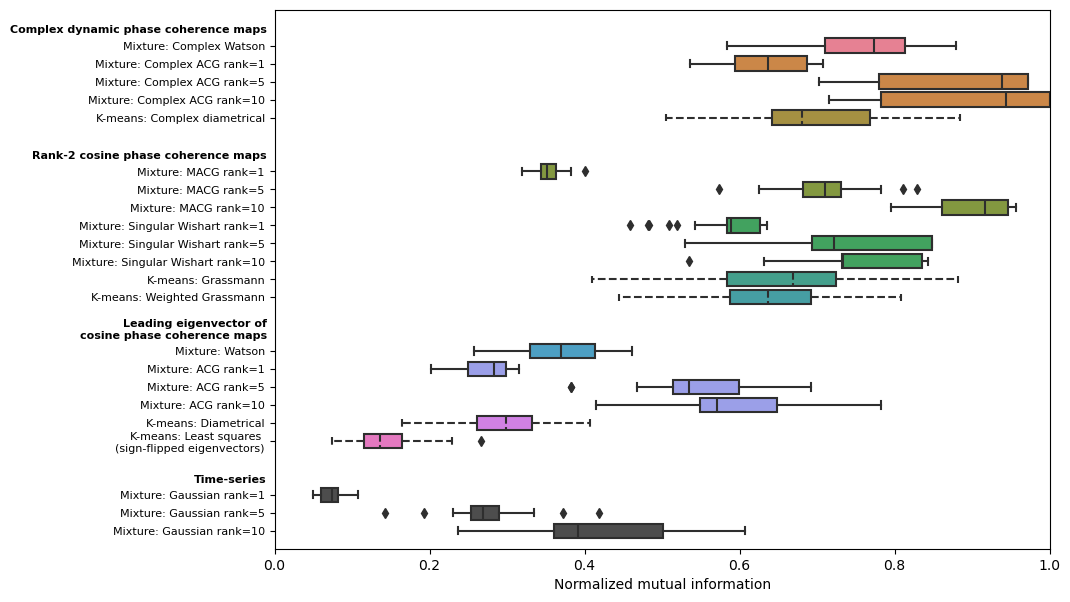

In [10]:
order = ['Mixture: Complex Watson',
         'Mixture: Complex ACG rank=1','Mixture: Complex ACG rank=5','Mixture: Complex ACG rank=10',
         'K-means: Complex diametrical','','',
         'Mixture: MACG rank=1','Mixture: MACG rank=5','Mixture: MACG rank=10',
         'Mixture: Singular Wishart rank=1','Mixture: Singular Wishart rank=5','Mixture: Singular Wishart rank=10',
         'K-means: Grassmann','K-means: Weighted Grassmann','','',
         'Mixture: Watson', 
         'Mixture: ACG rank=1','Mixture: ACG rank=5','Mixture: ACG rank=10',
         'K-means: Diametrical','K-means: Least squares \n(sign-flipped eigenvectors)','','',
         'Mixture: Gaussian rank=1','Mixture: Gaussian rank=5','Mixture: Gaussian rank=10']
styles = ['-']+['-']*3+['--']+['-']*3+['-']*3+['--']*2+['-']+['-']*3+['--']*2+['-']*3
#repeat every element of styles six times
styles2 = [item for item in styles for i in range(5)]
palette_husl = sns.color_palette("husl", n_colors=11, desat=1)
palette_husl.append((0.3,0.3,0.3))
palette_husl2 = [palette_husl[0]]+[palette_husl[1]]*3+[palette_husl[2]]*3+[palette_husl[3]]*3+[palette_husl[4]]*3+[palette_husl[5]]+[palette_husl[6]]*3+[palette_husl[7]]+[palette_husl[8]]*3+[palette_husl[9]]+[palette_husl[10]]*3+[palette_husl[11]]*3

df2 = df[df['group']=='EM']
df2 = df2[df2['initialization']=='All']
df_km = df_kmeans[df_kmeans['init_method']=='++']
df_fig = pd.concat([df2,df_km], ignore_index=True)

fig = plt.figure(figsize=(10,7))
sns.boxplot(x='train_NMI', y='names2', data=df_fig, palette=palette_husl2, order=order)
plt.xlabel('Normalized mutual information')
plt.ylabel('')
plt.xlim([0,1])
plt.ylim([28,-2])
plt.yticks(np.concatenate([np.arange(5),np.arange(8)+7,np.arange(6)+17,np.arange(3)+25]),fontsize=8)
# add extra text next to y-ticks that aren't there
plt.text(-0.01, -0.7, 'Complex dynamic phase coherence maps', fontsize=8,fontweight='bold', ha='right')
plt.text(-0.01, 6.3, 'Rank-2 cosine phase coherence maps', fontsize=8,fontweight='bold', ha='right')
plt.text(-0.01, 16.3, 'Leading eigenvector of\ncosine phase coherence maps', fontsize=8,fontweight='bold', ha='right')
plt.text(-0.01, 24.3, 'Time-series', fontsize=8,fontweight='bold', ha='right')

# change the line styles
l = 0
for i,artist in enumerate(plt.gca().get_children()):
    if isinstance(artist, plt.Line2D):
        #if linestyle is not none
        if artist.get_linestyle() != 'None':
            artist.set_linestyle(styles2[l])
            l+=1
# print(l)
plt.savefig('figures/torchvsEM_phase_narrowband_controlled_results_summarized3.png', bbox_inches='tight', dpi=300)